## Fukuro AMCL 

### A. Introduction and Importing Dependencies

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(-10, 11, 0.25)
y = 7 * np.sin(x)

dx = np.gradient(x)
dy = np.gradient(y)

print(y)

print(len(dy)

84
84


In [2]:
# Define the Particle for AMCL
class Particle:
    def __init__(self, x, y, theta, weight):
        self.x = x
        self.y = y
        self.theta = theta
        self.weight = weight

In [3]:
class AMCL:
    def __init__(self, 
                 num_particles, 
                 map_landmarks, 
                 initial_pose=None):
        self.num_particles = num_particles
        self.map_landmarks = map_landmarks
        self.particles = []

        # set random particles around initial pose using norm distribution
        # norm distribution helps us to decrease the probabilty of getting extremely wrong particles
        # because norm distribution will generate particles around initial position
        if initial_pose: 
            x, y, theta = initial_pose
            for _ in range(num_particles):
                noise_x = np.random.normal(x, 0.1)
                noise_y = np.random.normal(y, 0.1)
                noise_theta = np.random.normal(theta, 0.05)
                self.particles.append(Particle(x=noise_x, 
                                               y=noise_y, 
                                               theta=noise_theta, 
                                               weight=1.0/num_particles))

    def predict(self, u, noise):
        # generate random normal particles around robot
        std_x, std_y, std_theta = noise
        for p in self.particles:
            p.x += u[0] + np.random.normal(0, std_x)
            p.y += u[1] + np.random.normal(0, std_y)
            p.theta += u[2] + np.random.normal(0, std_theta)
            p.theta = (p.theta + np.pi) % (2 * np.pi) - np.pi
        
    def update(self, measurements, range_std, bearing_std): # update according to landmarks
        for p in self.particles:
            p.weight = 1.0
            for (landmark_id, measured_range, measured_bearing) in measurements:
                lx, ly = self.map_landmarks[landmark_id]
                dx = lx - p.x
                dy = ly - p.y
                expected_range = np.hypot(dx, dy)
                expected_bearing = np.arctan2(dy, dx) - p.theta
                expected_bearing = (expected_bearing + np.pi) % (2 * np.pi) - np.pi
                
                # calculating a likelihood
                prob_range = (1.0 / (range_std * np.sqrt(2 * np.pi))) * \
                           np.exp(-0.5 * ((measured_range - expected_range)/range_std)**2)
                prob_bearing = (1.0 / (bearing_std * np.sqrt(2 * np.pi))) * \
                             np.exp(-0.5 * ((measured_bearing - expected_bearing)/bearing_std)**2)
                p.weight *= prob_range * prob_bearing
        
        total_weight = sum(p.weight for p in self.particles)
        if total_weight == 0:
            for p in self.particles:
                p.weight = 1.0 / self.num_particles
        else:
            for p in self.particles:
                p.weight /= total_weight

    def resample(self):
        weights = [p.weight for p in self.particles]
        cumulative_weights = np.cumsum(weights)
        step = cumulative_weights[-1] / self.num_particles
        start = np.random.uniform(0, step)
        
        indexes = []
        for i in range(self.num_particles):
            pointer = start + i * step
            index = np.searchsorted(cumulative_weights, pointer)
            indexes.append(index % len(self.particles))
        
        new_particles = [Particle(self.particles[i].x, self.particles[i].y,
                                 self.particles[i].theta, 1.0/self.num_particles)
                        for i in indexes]
        self.particles = new_particles

    def get_estimated_pose(self):
        x = sum(p.x * p.weight for p in self.particles)
        y = sum(p.y * p.weight for p in self.particles)
        sin_sum = sum(np.sin(p.theta) * p.weight for p in self.particles)
        cos_sum = sum(np.cos(p.theta) * p.weight for p in self.particles)
        theta = np.arctan2(sin_sum, cos_sum)
        return (x, y, theta)

In [4]:
class AMCLVisualizer:
    def __init__(self, amcl, landmarks, true_pose):
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.amcl = amcl
        self.landmarks = landmarks
        self.true_pose = true_pose
        self.setup_plot()
        
    def setup_plot(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        self.ax.set_title("AMCL Localization with Landmarks")
        self.ax.set_xlabel("X position")
        self.ax.set_ylabel("Y position")
        
        # Plot landmarks
        for lid, pos in self.landmarks.items():
            self.ax.scatter(pos[0], pos[1], s=100, marker='*', color='orange', label='Landmarks' if lid == 0 else "")
        
        # Initial plots
        self.particle_plot = self.ax.scatter([], [], s=5, alpha=0.5, color='blue', label='Particles')
        self.true_pose_plot = self.ax.quiver([], [], [], [], color='red', scale=20, label='True Pose')
        self.estimated_pose_plot = self.ax.quiver([], [], [], [], color='green', scale=20, label='Estimated Pose')
        self.ax.legend()
        
    def update_plot(self):
        # Clear previous poses
        self.true_pose_plot.remove()
        self.estimated_pose_plot.remove()
        
        # Update particles
        particles = self.amcl.particles
        x = [p.x for p in particles]
        y = [p.y for p in particles]
        self.particle_plot.set_offsets(np.c_[x, y])
        
        # Update true pose
        tx, ty, ttheta = self.true_pose
        self.true_pose_plot = self.ax.quiver(tx, ty, np.cos(ttheta), np.sin(ttheta), 
                                            color='red', scale=20)
        
        # Update estimated pose
        ex, ey, etheta = self.amcl.get_estimated_pose()
        self.estimated_pose_plot = self.ax.quiver(ex, ey, np.cos(etheta), np.sin(etheta), 
                                                 color='green', scale=20)
        
        plt.draw()
        plt.pause(0.1)

def simulate_robot_movement(true_pose, control_input):
    noise = np.random.normal(0, [0.05, 0.05, 0.02])
    new_pose = (
        true_pose[0] + control_input[0] + noise[0],
        true_pose[1] + control_input[1] + noise[1],
        (true_pose[2] + control_input[2] + noise[2]) % (2 * np.pi)
    )
    return new_pose

def generate_measurements(true_pose, landmarks, range_std=0.1, bearing_std=0.05):
    measurements = []
    for landmark_id, (lx, ly) in landmarks.items():
        dx = lx - true_pose[0]
        dy = ly - true_pose[1]
        distance = np.hypot(dx, dy)
        bearing = np.arctan2(dy, dx) - true_pose[2]
        bearing = (bearing + np.pi) % (2 * np.pi) - np.pi
        measurements.append((
            landmark_id,
            distance + np.random.normal(0, range_std),
            bearing + np.random.normal(0, bearing_std)
        ))
    return measurements

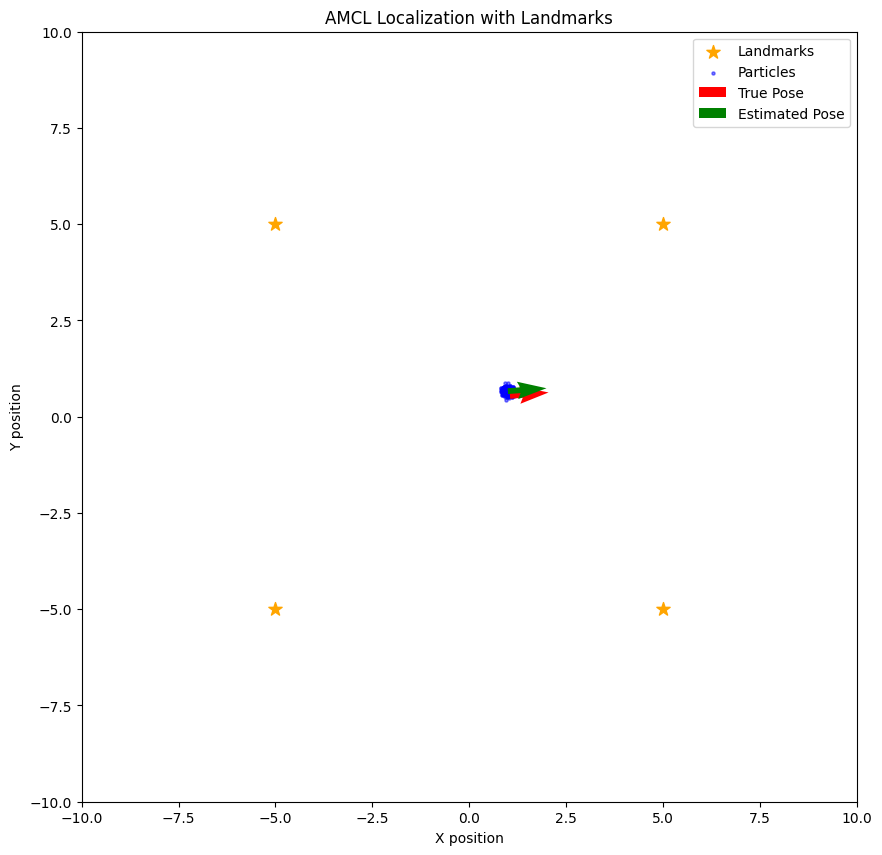

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# Simulation parameters
landmarks = {
    0: (5.0, 5.0),
    1: (5.0, -5.0),
    2: (-5.0, 5.0),
    3: (-5.0, -5.0),
}
num_steps = 10
control_inputs = [(1.0, 0.5, 0.1)] * num_steps

# Initialize AMCL and visualizer
true_pose = (0, 0, 0)
amcl = AMCL(1000, landmarks, initial_pose=true_pose)
vis = AMCLVisualizer(amcl, landmarks, true_pose)

# Simulation loop
for i, u in enumerate(control_inputs):
    # Move robot and get new true pose
    true_pose = simulate_robot_movement(true_pose, u) # true pos setelah noise
    
    # Generate measurements from new true pose
    measurements = generate_measurements(true_pose, landmarks)
    
    # AMCL steps
    amcl.predict(u, (0.1, 0.1, 0.05))
    amcl.update(measurements, 0.1, 0.05)
    amcl.resample()
    
    # Update visualization
    vis.true_pose = true_pose
    vis.update_plot()

plt.show()